In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import copy


In [3]:
# Path to the root folder of your dataset
dataset_root = 'D:\sem8Project\Indian Medicinal Leaves Image Datasets\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset'


In [5]:
csv_file_path = 'dataset.csv'

In [3]:

# Create a CSV file to store image paths and labels

with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['image_path', 'class_label'])  # Write header

    # Iterate through labeled folders
    for class_label in os.listdir(dataset_root):
        class_folder_path = os.path.join(dataset_root, class_label)

        # Check if the item in the folder is a directory
        if os.path.isdir(class_folder_path):
            # Iterate through images in the labeled folder
            for image_file in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_file)
                csv_writer.writerow([image_path, class_label])

print(f"CSV file created at: {csv_file_path}")


CSV file created at: dataset.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6900 entries, 0 to 6899
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   6900 non-null   object
 1   class_label  6900 non-null   object
dtypes: object(2)
memory usage: 107.9+ KB
None


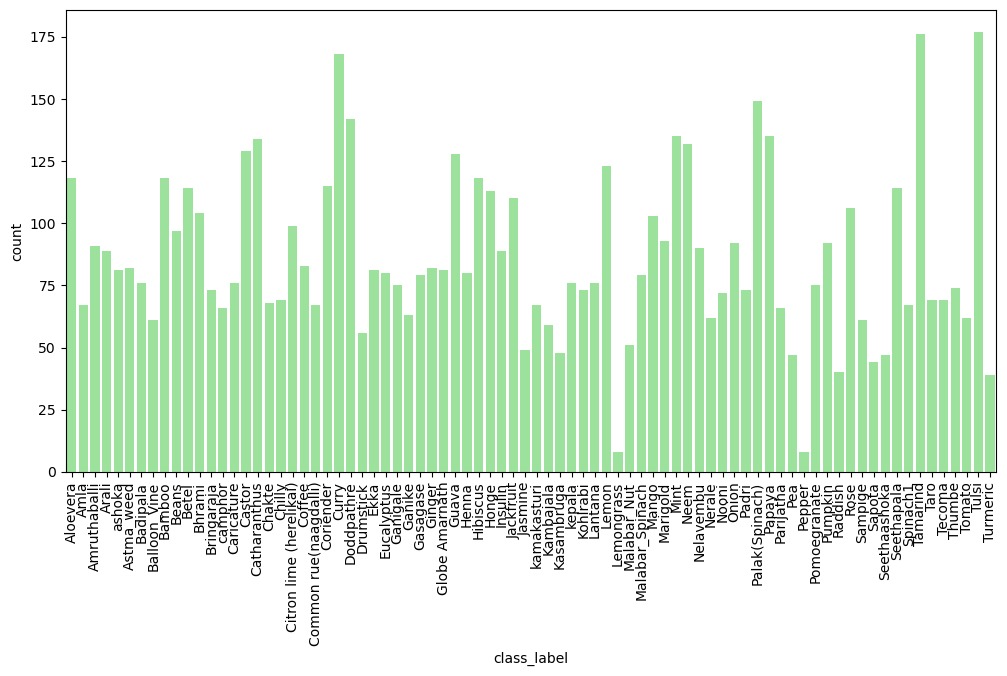

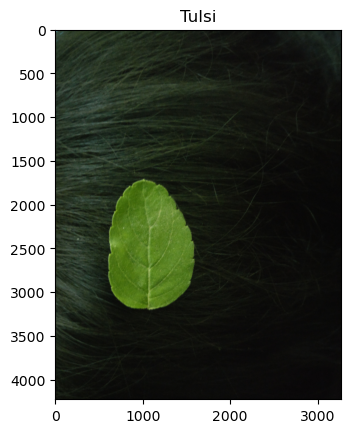

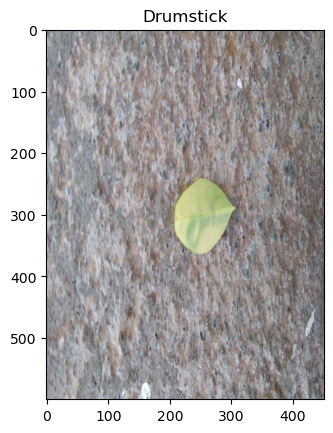

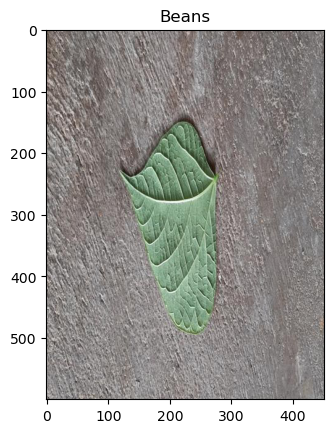

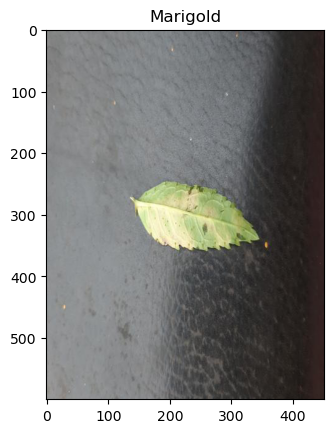

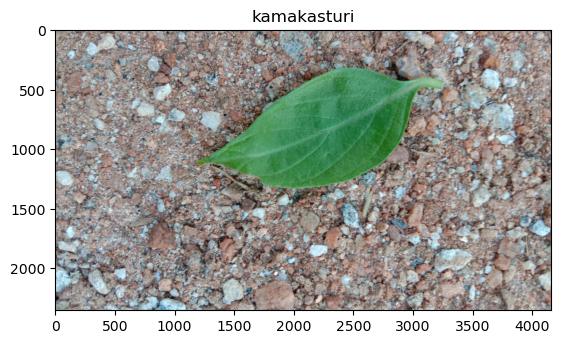

In [6]:
# Assuming you have a CSV file with image paths and labels
data_path = csv_file_path
df = pd.read_csv(data_path)

# Display basic statistics
print(df.info())

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='class_label', data=df, color = 'lightgreen')
plt.xticks(rotation=90)
plt.show()

# Display random images
def display_random_images(df, num_images=5):
    random_samples = df.sample(num_images)
    for index, row in random_samples.iterrows():
        img = load_img(row['image_path'])
        plt.imshow(img)
        plt.title(row['class_label'])
        plt.show()

display_random_images(df)


In [7]:

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Display the class distribution in text form
class_distribution = df['class_label'].value_counts()
print("Class Distribution:")
print(class_distribution)

# Reset pandas display options to the default
pd.reset_option('display.max_rows')

Class Distribution:
class_label
Tulsi                      177
Tamarind                   176
Curry                      168
Palak(Spinach)             149
Doddpathre                 142
Mint                       135
Papaya                     135
Catharanthus               134
Neem                       132
Castor                     129
Guava                      128
Lemon                      123
Hibiscus                   118
Aloevera                   118
Bamboo                     118
Coriender                  115
Seethapala                 114
Betel                      114
Honge                      113
Jackfruit                  110
Rose                       106
Bhrami                     104
Mango                      103
Citron lime (herelikai)     99
Beans                       97
Marigold                    93
Pumpkin                     92
Onion                       92
Amruthaballi                91
Nelavembu                   90
Insulin                     89
Arali  

In [9]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
import pandas as pd

# Assuming df is your DataFrame with 'image_path' and 'class_label' columns

# Set the target number of images per class
target_images_per_class = 101

# Set the directory where augmented images will be saved
output_directory = 'augmented_images'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Create a list to store information for augmented images
augmented_images_info = []

# Iterate through each class
for class_label in df['class_label'].unique():
    class_df = df[df['class_label'] == class_label]
    
    # Print a message before augmentation starts for each class
    print(f"\nClass '{class_label}': Original Images: {len(class_df)}")
    
    # Check if the class has fewer than the target number of images
    if len(class_df) < target_images_per_class:
        # Print message
        print(f"Augmentation required!")
        # Calculate the number of additional images needed
        num_additional_images = target_images_per_class - len(class_df)
        
        # Create an ImageDataGenerator with desired augmentations
        datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=45,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

        # Randomly select images from the class to augment
        selected_images = class_df.sample(n=num_additional_images, replace=True)

        # Iterate through selected images and apply data augmentation
        for _, row in selected_images.iterrows():
            image_path = row['image_path']
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.reshape((1,) + img.shape)
            augmented_image = next(datagen.flow(img)).squeeze()

            # Save the augmented image to disk
            file_name = f'{class_label}_{len(os.listdir(output_directory)) + 1}.png'
            output_path = os.path.join(output_directory, file_name)
            cv2.imwrite(output_path, cv2.cvtColor((augmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            
            # Store information for the augmented image in the list
            augmented_images_info.append({'image_path': output_path, 'class_label': class_label})
            
        # Print a message for each class iteration
        print(f"Class '{class_label}': Augmented {num_additional_images} images.")

# Create a new DataFrame from the list of augmented images
augmented_df = pd.DataFrame(augmented_images_info)

# Concatenate the original DataFrame with the augmented DataFrame
df2 = copy.deepcopy(df)
df2 = pd.concat([df2, augmented_df], ignore_index=True)


Class 'Aloevera': Original Images: 118

Class 'Amla': Original Images: 67
Augmentation required!
Class 'Amla': Augmented 34 images.

Class 'Amruthaballi': Original Images: 91
Augmentation required!
Class 'Amruthaballi': Augmented 10 images.

Class 'Arali': Original Images: 89
Augmentation required!
Class 'Arali': Augmented 12 images.

Class 'ashoka': Original Images: 81
Augmentation required!
Class 'ashoka': Augmented 20 images.

Class 'Astma_weed': Original Images: 82
Augmentation required!
Class 'Astma_weed': Augmented 19 images.

Class 'Badipala': Original Images: 76
Augmentation required!
Class 'Badipala': Augmented 25 images.

Class 'Balloon_Vine': Original Images: 61
Augmentation required!
Class 'Balloon_Vine': Augmented 40 images.

Class 'Bamboo': Original Images: 118

Class 'Beans': Original Images: 97
Augmentation required!
Class 'Beans': Augmented 4 images.

Class 'Betel': Original Images: 114

Class 'Bhrami': Original Images: 104

Class 'Bringaraja': Original Images: 73
Aug

In [10]:
# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Display the class distribution in text form
class_distribution = df2['class_label'].value_counts()
print("Class Distribution:")
print(class_distribution)

# Reset pandas display options to the default
pd.reset_option('display.max_rows')

Class Distribution:
class_label
Tulsi                      177
Tamarind                   176
Curry                      168
Palak(Spinach)             149
Doddpathre                 142
Mint                       135
Papaya                     135
Catharanthus               134
Neem                       132
Castor                     129
Guava                      128
Lemon                      123
Hibiscus                   118
Aloevera                   118
Bamboo                     118
Coriender                  115
Seethapala                 114
Betel                      114
Honge                      113
Jackfruit                  110
Rose                       106
Bhrami                     104
Mango                      103
Thumbe                     101
Tecoma                     101
Nelavembu                  101
Sapota                     101
Tomato                     101
Taro                       101
Marigold                   101
Malabar_Spinach            101
Malabar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8718 entries, 0 to 8717
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   8718 non-null   object
 1   class_label  8718 non-null   object
dtypes: object(2)
memory usage: 136.3+ KB
None


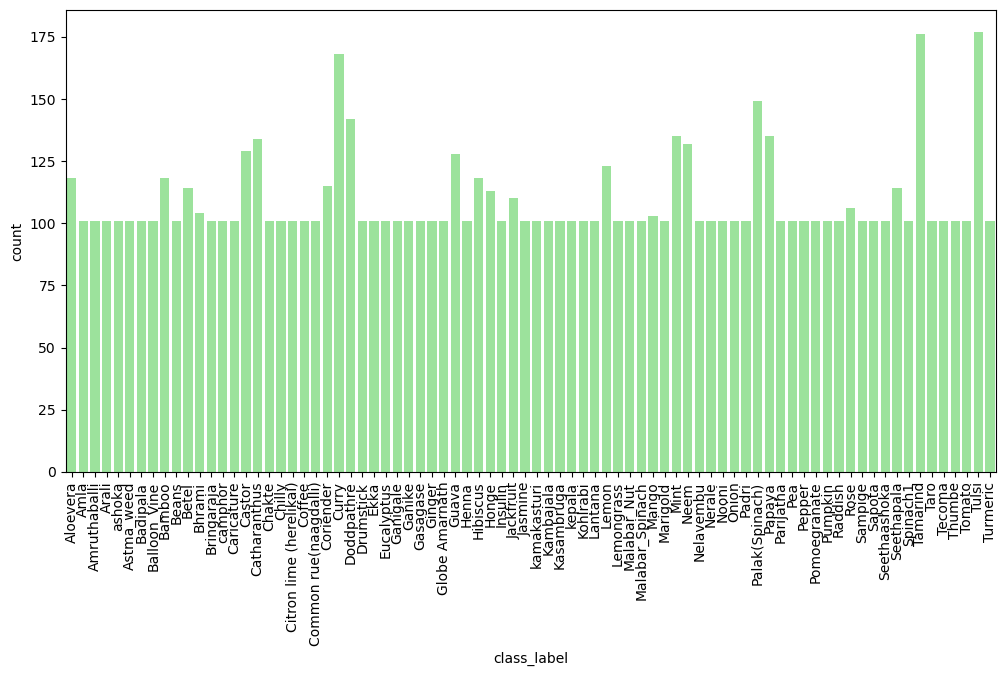

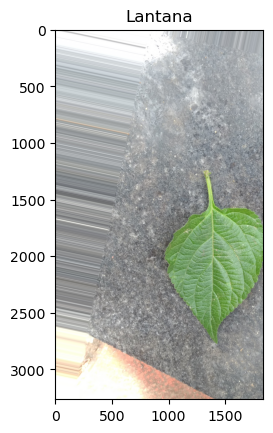

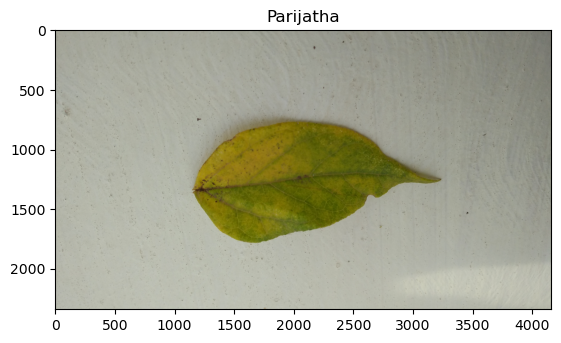

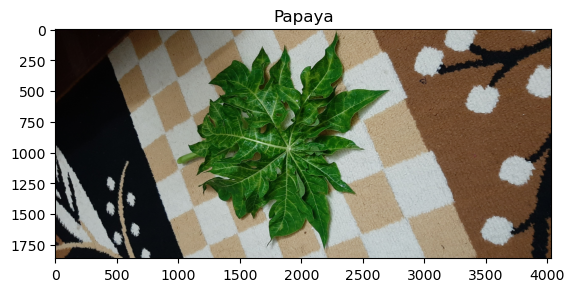

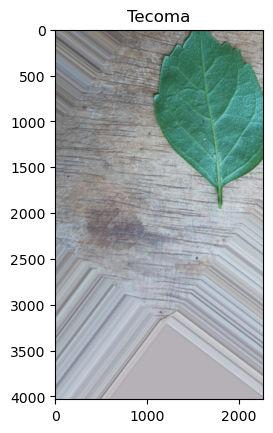

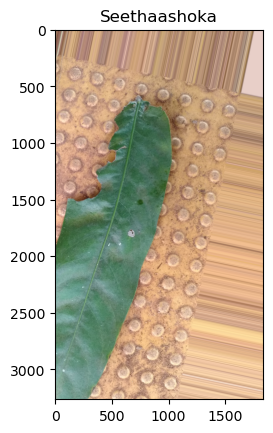

In [11]:
# Display basic statistics
print(df2.info())

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='class_label', data=df2, color = 'lightgreen')
plt.xticks(rotation=90)
plt.show()

# Display random images
def display_random_images(df2, num_images=5):
    random_samples = df2.sample(num_images)
    for index, row in random_samples.iterrows():
        img = load_img(row['image_path'])
        plt.imshow(img)
        plt.title(row['class_label'])
        plt.show()

display_random_images(df2)

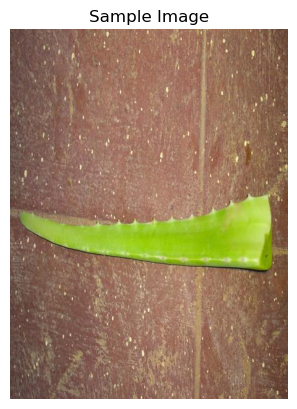

Mean Pixel Intensity: [147.53000741 118.43437778  86.66324074]
Standard Deviation of Pixel Intensity: [25.06488209 34.12105407 24.14059722]


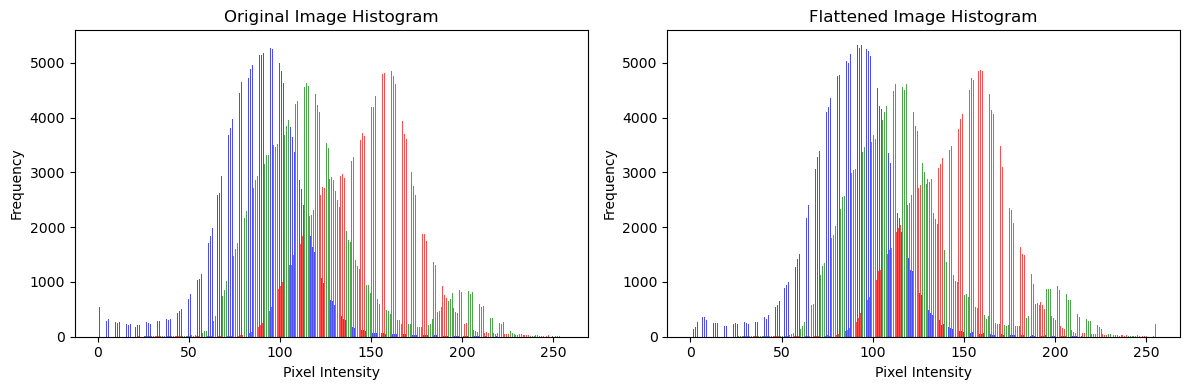

In [12]:

# Function to calculate image statistics
def calculate_image_statistics(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_flat = img.reshape(-1, 3)  # Flatten the image to a 1D array

    # Calculate mean and standard deviation
    mean_pixel = np.mean(img_flat, axis=0)
    std_pixel = np.std(img_flat, axis=0)

    return mean_pixel, std_pixel, img, img_flat  # Include img_flat in the return values

# Sample usage for a single image
image_path_sample = df2['image_path'].iloc[0]
mean_pixel, std_pixel, sample_image, img_flat = calculate_image_statistics(image_path_sample)

# Display the sample image
plt.imshow(sample_image)
plt.title('Sample Image')
plt.axis('off')
plt.show()

# Display image statistics
print(f'Mean Pixel Intensity: {mean_pixel}')
print(f'Standard Deviation of Pixel Intensity: {std_pixel}')

# Visualize the color histogram
plt.figure(figsize=(12, 4))

# Original image histogram
plt.subplot(1, 2, 1)
plt.hist(sample_image.reshape(-1, 3), bins=256, color=['red', 'green', 'blue'], range=[0, 256], alpha=0.7)
plt.title('Original Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Flattened image histogram
plt.subplot(1, 2, 2)
plt.hist(img_flat, bins=256, color=['red', 'green', 'blue'], range=[0, 256], alpha=0.7)
plt.title('Flattened Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


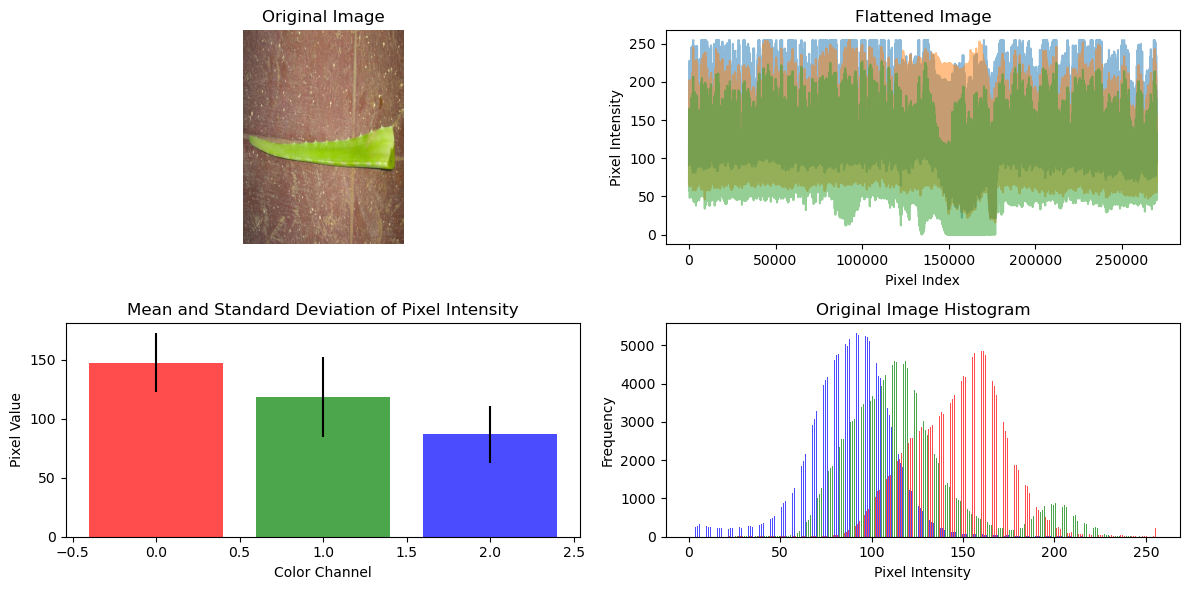

In [13]:

# Function to calculate image statistics
def calculate_image_statistics(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_flat = img.reshape(-1, 3)  # Flatten the image to a 1D array

    # Calculate mean and standard deviation
    mean_pixel = np.mean(img_flat, axis=0)
    std_pixel = np.std(img_flat, axis=0)

    return mean_pixel, std_pixel, img, img_flat  # Include img_flat in the return values

# Sample usage for a single image
image_path_sample = df2['image_path'].iloc[0]
mean_pixel, std_pixel, sample_image, img_flat = calculate_image_statistics(image_path_sample)

# Display the sample image and its flattened representation
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')
plt.axis('off')

# Flattened image
plt.subplot(2, 2, 2)
plt.plot(img_flat, alpha=0.5)
plt.title('Flattened Image')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Intensity')

# Display image statistics
plt.subplot(2, 2, 3)
plt.bar(range(3), mean_pixel, yerr=std_pixel, color=['red', 'green', 'blue'], alpha=0.7)
plt.title('Mean and Standard Deviation of Pixel Intensity')
plt.xlabel('Color Channel')
plt.ylabel('Pixel Value')

# Visualize the color histogram of the original image
plt.subplot(2, 2, 4)
plt.hist(sample_image.reshape(-1, 3), bins=256, color=['red', 'green', 'blue'], range=[0, 256], alpha=0.7)
plt.title('Original Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Function to plot distribution of image sizes
def plot_image_size_distribution(image_paths):
    widths = []
    heights = []

    for image_path in image_paths:
        img = cv2.imread(image_path)
        height, width, _ = img.shape
        widths.append(width)
        heights.append(height)
    
    print(np.mean(widths))
    print(np.mean(heights))

    

# Sample usage to plot image size distribution
plot_image_size_distribution(df2['image_path'])


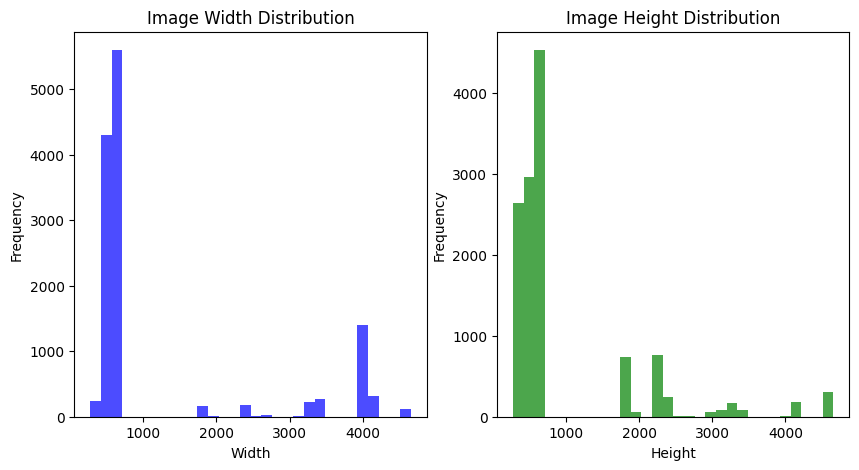

## Model Initialization


### Model 1

In [57]:
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras

In [58]:
img_width,img_height=224,224

model=MobileNetV2(weights='imagenet',
                include_top=False,
                input_shape=(img_height,img_width,3)
                )

In [59]:
for (i,layer) in enumerate(model.layers):
    print(f"{i} {layer.__class__.__name__} {layer.trainable}")

0 InputLayer True
1 Conv2D True
2 BatchNormalization True
3 ReLU True
4 DepthwiseConv2D True
5 BatchNormalization True
6 ReLU True
7 Conv2D True
8 BatchNormalization True
9 Conv2D True
10 BatchNormalization True
11 ReLU True
12 ZeroPadding2D True
13 DepthwiseConv2D True
14 BatchNormalization True
15 ReLU True
16 Conv2D True
17 BatchNormalization True
18 Conv2D True
19 BatchNormalization True
20 ReLU True
21 DepthwiseConv2D True
22 BatchNormalization True
23 ReLU True
24 Conv2D True
25 BatchNormalization True
26 Add True
27 Conv2D True
28 BatchNormalization True
29 ReLU True
30 ZeroPadding2D True
31 DepthwiseConv2D True
32 BatchNormalization True
33 ReLU True
34 Conv2D True
35 BatchNormalization True
36 Conv2D True
37 BatchNormalization True
38 ReLU True
39 DepthwiseConv2D True
40 BatchNormalization True
41 ReLU True
42 Conv2D True
43 BatchNormalization True
44 Add True
45 Conv2D True
46 BatchNormalization True
47 ReLU True
48 DepthwiseConv2D True
49 BatchNormalization True
50 ReLU True

In [60]:
for layer in model.layers:
    layer.trainable=False

In [61]:
for (i,layer) in enumerate(model.layers):
    print(f"{i} {layer.__class__.__name__} {layer.trainable}")

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 Conv2D False
10 BatchNormalization False
11 ReLU False
12 ZeroPadding2D False
13 DepthwiseConv2D False
14 BatchNormalization False
15 ReLU False
16 Conv2D False
17 BatchNormalization False
18 Conv2D False
19 BatchNormalization False
20 ReLU False
21 DepthwiseConv2D False
22 BatchNormalization False
23 ReLU False
24 Conv2D False
25 BatchNormalization False
26 Add False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 ZeroPadding2D False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 Conv2D False
37 BatchNormalization False
38 ReLU False
39 DepthwiseConv2D False
40 BatchNormalization False
41 ReLU False
42 Conv2D False
43 BatchNormalization False
44 Add False
45 Conv2D False
46 BatchNormalization False
47 ReLU False
48 DepthwiseCon

In [62]:
def add_layer_at_bottom(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

### Training

In [63]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [74]:
import tensorflow as tf

# Load the model from 'model.h5'
loaded_model = tf.keras.models.load_model('Model.keras')

# Display the model architecture
loaded_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 11,039,538 (42.11 MB)

 Trainable params: 2,927,184 (11.17 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 5,854,370 (22.33 MB)

In [66]:
df2

image_path class_label  \
0     D:\sem8Project\Indian Medicinal Leaves Image D...    Aloevera   
1     D:\sem8Project\Indian Medicinal Leaves Image D...    Aloevera   
2     D:\sem8Project\Indian Medicinal Leaves Image D...    Aloevera   
3     D:\sem8Project\Indian Medicinal Leaves Image D...    Aloevera   
4     D:\sem8Project\Indian Medicinal Leaves Image D...    Aloevera   
...                                                 ...         ...   
8713                 augmented_images\Turmeric_1814.png    Turmeric   
8714                 augmented_images\Turmeric_1815.png    Turmeric   
8715                 augmented_images\Turmeric_1816.png    Turmeric   
8716                 augmented_images\Turmeric_1817.png    Turmeric   
8717                 augmented_images\Turmeric_1818.png    Turmeric   

                                                  image  
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...  
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...  
...                                                 ...  
8713  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
8714  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
8715  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
8716  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
8717  <PIL.PngImagePlugin.PngImageFile image mode=RG...  

[8718 rows x 3 columns]

In [67]:
from PIL import Image
def load_image(image_path):
    with open(image_path, 'rb') as file:
        return Image.open(file)

# Load images from DataFrame
df2['image'] = df2['image_path'].apply(load_image)

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(df2, test_size=0.2, random_state=42)

# Print the number of samples in each set
print("Number of samples in training set:", len(train_df))
print("Number of samples in test set:", len(test_df))

# Print the first few rows of train and test sets
print("\nFirst few rows of training set:")
print(train_df.head())

print("\nFirst few rows of test set:")
print(test_df.head())

Number of samples in training set: 6974
Number of samples in test set: 1744

First few rows of training set:
                                             image_path  class_label  \
805   D:\sem8Project\Indian Medicinal Leaves Image D...        Beans   
3011  D:\sem8Project\Indian Medicinal Leaves Image D...        Guava   
7899              augmented_images\Malabar_Nut_1000.png  Malabar_Nut   
1962  D:\sem8Project\Indian Medicinal Leaves Image D...    Coriender   
3187  D:\sem8Project\Indian Medicinal Leaves Image D...        Henna   

                                                  image  
805   <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3011  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
7899  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
1962  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3187  <PIL.JpegImagePlugin.JpegImageFile image mode=...  

First few rows of test set:
                                             image_path class_label  \
682   D:\s

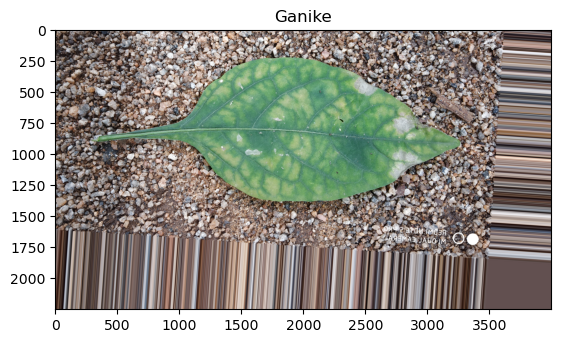

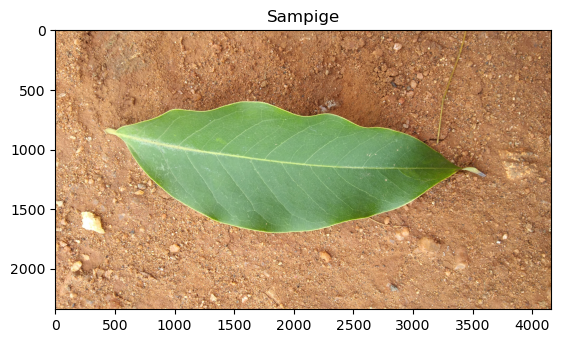

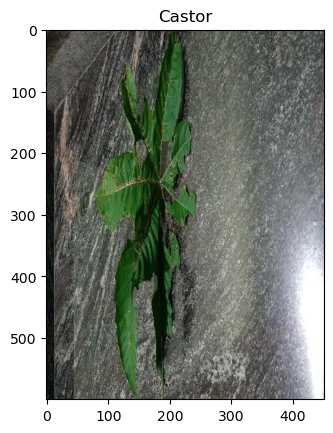

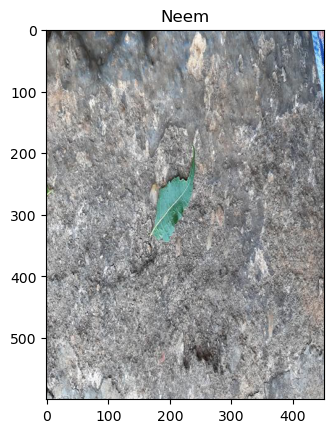

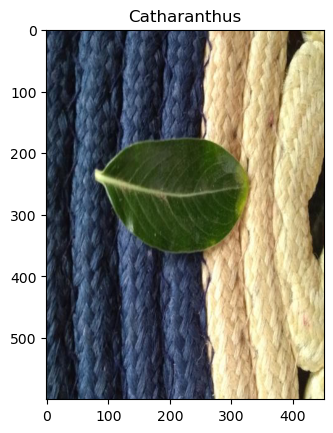

In [68]:
def display_random_images(df, num_images=5):
    random_samples = df.sample(num_images)
    for index, row in random_samples.iterrows():
        img = load_img(row['image_path'])
        plt.imshow(img)
        plt.title(row['class_label'])
        plt.show()

display_random_images(train_df)

In [69]:
# Define data generators for train and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',  # Assuming 'image_path' is the column containing image paths
    y_col='class_label',       # Assuming 'label' is the column containing class labels
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',  # Assuming 'image_path' is the column containing image paths
    y_col='class_label',       # Assuming 'label' is the column containing class labels
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 6974 validated image filenames belonging to 80 classes.
Found 1744 validated image filenames belonging to 80 classes.


In [70]:
train_class_names = set()
num_train_samples = 0

# Assuming 'image_path' is the column containing the image paths
for path in train_df['image_path']:
    train_class_names.add(path.split('\\')[1])
    num_train_samples += 1

print("Number of train samples:", num_train_samples)
train_class_names

Number of train samples: 6974


{'Amla_33.png',
 'camphor_202.png',
 'Tecoma_1670.png',
 'Parijatha_1178.png',
 'Drumstick_402.png',
 'Malabar_Nut_985.png',
 'Raddish_1411.png',
 'Caricature_241.png',
 'Gasagase_542.png',
 'kepala_806.png',
 'Jasmine_648.png',
 'Pomoegranate_1351.png',
 'Jasmine_644.png',
 'Ekka_433.png',
 'kamakasturi_677.png',
 'kamakasturi_697.png',
 'Nooni_1107.png',
 'Kambajala_741.png',
 'Spinach1_1604.png',
 'Balloon_Vine_150.png',
 'Jasmine_654.png',
 'Ganike_506.png',
 'Globe Amarnath_567.png',
 'Chakte_272.png',
 'Sapota_1502.png',
 'Sapota_1493.png',
 'Drumstick_384.png',
 'Sapota_1491.png',
 'Seethaashoka_1576.png',
 'Malabar_Nut_983.png',
 'Tecoma_1685.png',
 'Jasmine_618.png',
 'Lemongrass_890.png',
 'Kasambruga_796.png',
 'Pea_1245.png',
 'Pepper_1316.png',
 'Nooni_1124.png',
 'Padri_1160.png',
 'Drumstick_387.png',
 'Nooni_1116.png',
 'Ganike_516.png',
 'Raddish_1420.png',
 'Spinach1_1605.png',
 'Raddish_1430.png',
 'Pomoegranate_1356.png',
 'Gasagase_523.png',
 'Kambajala_738.png',
 

In [71]:
val_class_names = set()
num_val_samples = 0

# Assuming 'image_path' is the column containing the image paths
for path in test_df['image_path']:
    val_class_names.add(path.split('\\')[1])
    num_val_samples += 1

print("Number of validation samples:", num_val_samples)
val_class_names

Number of validation samples: 1744


{'Amla_10.png',
 'Amla_12.png',
 'Amla_18.png',
 'Amla_27.png',
 'Amla_3.png',
 'Amla_34.png',
 'Amla_7.png',
 'Amla_9.png',
 'Amruthaballi_41.png',
 'Arali_47.png',
 'Arali_52.png',
 'Astma_weed_84.png',
 'Badipala_102.png',
 'Badipala_113.png',
 'Badipala_116.png',
 'Badipala_96.png',
 'Balloon_Vine_147.png',
 'Balloon_Vine_148.png',
 'Balloon_Vine_154.png',
 'Balloon_Vine_156.png',
 'Beans_164.png',
 'Bringaraja_176.png',
 'Bringaraja_182.png',
 'Bringaraja_185.png',
 'Caricature_229.png',
 'Caricature_234.png',
 'Caricature_244.png',
 'Caricature_245.png',
 'Caricature_246.png',
 'Caricature_249.png',
 'Chakte_257.png',
 'Chakte_258.png',
 'Chakte_261.png',
 'Chakte_271.png',
 'Chakte_278.png',
 'Chakte_280.png',
 'Chakte_284.png',
 'Chilly_292.png',
 'Chilly_296.png',
 'Chilly_311.png',
 'Chilly_317.png',
 'Coffee_321.png',
 'Coffee_324.png',
 'Coffee_331.png',
 'Coffee_335.png',
 'Coffee_337.png',
 'Common rue(naagdalli)_343.png',
 'Common rue(naagdalli)_350.png',
 'Common rue(na

In [75]:
num_classes=len(train_generator.class_indices)
print(num_classes)
FC_head=add_layer_at_bottom(model,
                            num_classes)

main_model=Model(inputs=model.input,
                 outputs=FC_head)

main_model.summary()

80


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 5,185,168 (19.78 MB)

 Trainable params: 2,927,184 (11.17 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [76]:

checkpoint = ModelCheckpoint("Model.keras",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=2,
                          verbose=1,
                          restore_best_weights=True)

callbacks=[checkpoint,earlystop]

main_model.compile(loss='categorical_crossentropy',
                   optimizer=Adam(learning_rate=0.001),
                   metrics=['accuracy'])

epochs=6

batch_size = 32

history = main_model.fit(train_generator,
                         steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                         callbacks=callbacks,
                         validation_data=validation_generator,
                         validation_steps=num_val_samples//batch_size)



Epoch 1/6
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2452 - loss: 3.1757
Epoch 1: val_loss improved from inf to 1.37099, saving model to Model.keras
217/217 ━━━━━━━━━━━━━━━━━━━━ 663s 3s/step - accuracy: 0.2460 - loss: 3.1718 - val_accuracy: 0.6140 - val_loss: 1.3710
Epoch 2/6
  1/217 ━━━━━━━━━━━━━━━━━━━━ 2:22 660ms/step - accuracy: 0.6250 - loss: 1.5627
Epoch 2: val_loss improved from 1.37099 to 0.97338, saving model to Model.keras
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6250 - loss: 1.5627 - val_accuracy: 0.6875 - val_loss: 0.9734
Epoch 3/6
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7351 - loss: 0.9179
Epoch 3: val_loss did not improve from 0.97338
217/217 ━━━━━━━━━━━━━━━━━━━━ 623s 3s/step - accuracy: 0.7351 - loss: 0.9177 - val_accuracy: 0.7106 - val_loss: 1.0244
Epoch 4/6
  1/217 ━━━━━━━━━━━━━━━━━━━━ 2:22 660ms/step - accuracy: 0.7188 - loss: 0.6199
Epoch 4: val_loss improved from 0.97338 to 0.85405, saving model to Model.keras
217/217 ━━━━━━━━━━

In [77]:
main_model.save('Model1.keras')

In [78]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

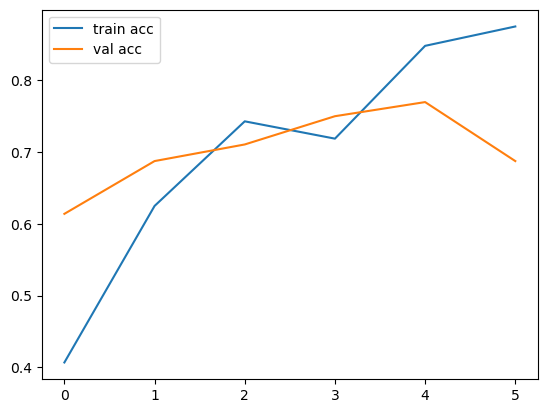

In [79]:
#accuracy
plt.plot(history.history['accuracy'], label= 'train acc')
plt.plot(history.history['val_accuracy'], label= 'val acc')
plt.legend()
# plt.saveig('vcc-acc-rps-1.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

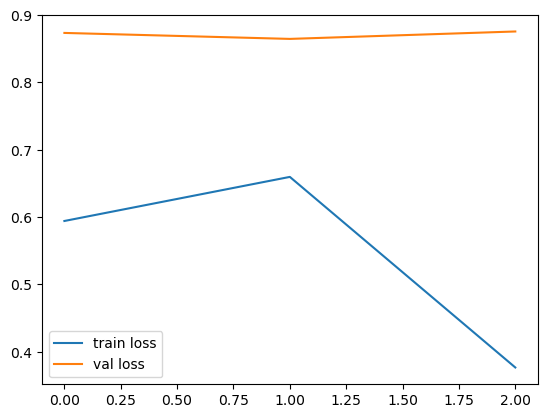

In [35]:
#loss
plt.plot(history.history['loss'], label= 'train loss')
plt.plot(history.history['val_loss'], label= 'val loss')
plt.legend()
# plt.saveig('vcc-loss-rps-1.png')
plt.show

In [81]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# List of class labels
out=['Aloevera',
 'Amla',
 'Amruthaballi',
 'Arali',
 'Astma_weed',
 'Badipala',
 'Balloon_Vine',
 'Bamboo',
 'Beans',
 'Betel',
 'Bhrami',
 'Bringaraja',
 'Caricature',
 'Castor',
 'Catharanthus',
 'Chakte',
 'Chilly',
 'Citron lime (herelikai)',
 'Coffee',
 'Common rue(naagdalli)',
 'Coriender',
 'Curry',
 'Doddpathre',
 'Drumstick',
 'Ekka',
 'Eucalyptus',
 'Ganigale',
 'Ganike',
 'Gasagase',
 'Ginger',
 'Globe Amarnath',
 'Guava',
 'Henna',
 'Hibiscus',
 'Honge',
 'Insulin',
 'Jackfruit',
 'Jasmine',
 'Kambajala',
 'Kasambruga',
 'Kohlrabi',
 'Lantana',
 'Lemon',
 'Lemongrass',
 'Malabar_Nut',
 'Malabar_Spinach',
 'Mango',
 'Marigold',
 'Mint',
 'Neem',
 'Nelavembu',
 'Nerale',
 'Nooni',
 'Onion',
 'Padri',
 'Palak(Spinach)',
 'Papaya',
 'Parijatha',
 'Pea',
 'Pepper',
 'Pomoegranate',
 'Pumpkin',
 'Raddish',
 'Rose',
 'Sampige',
 'Sapota',
 'Seethaashoka',
 'Seethapala',
 'Spinach1',
 'Tamarind',
 'Taro',
 'Tecoma',
 'Thumbe',
 'Tomato',
 'Tulsi',
 'Turmeric',
 'ashoka',
 'augmented_images',
 'camphor',
 'kamakasturi',
 'kepala'
 ]

def predict_image(image_path, model):
    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.
    img = img.reshape(1, 224, 224, 3)

    # Make predictions
    prediction = model.predict(img)
    
    # Get the predicted class index
    predicted_index = np.argmax(prediction)
    
    # Get the predicted class label
    predicted_class = out[predicted_index]
    
    return predicted_class

# Provide the image path
image_path = "2.jpg"

# Predict using main_model
predicted_class_main_model = predict_image(image_path, main_model)
print("Predicted Class using main_model:", predicted_class_main_model)

# Load Model1.keras
model1 = load_model('Model1.keras')

# Predict using Model1.keras
predicted_class_model1 = predict_image(image_path, model1)
print("Predicted Class using Model1.keras:", predicted_class_model1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class using main_model: Aloevera
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
Predicted Class using Model1.keras: Aloevera


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[9.9999857e-01 5.6744522e-11 4.1745725e-13 7.0804538e-13 8.2604919e-13
  5.8976019e-12 2.2862425e-13 1.9754107e-07 6.7587741e-11 2.8109442e-11
  2.1038937e-12 3.2615328e-13 6.1840857e-09 8.2906433e-12 1.2446835e-13
  5.8023406e-11 6.5798339e-10 6.6348242e-12 1.6656564e-13 1.2911390e-10
  5.7149691e-10 5.2291682e-10 1.8731650e-10 4.9427223e-11 8.2019669e-12
  3.6594841e-07 3.3545965e-11 6.6891384e-14 2.0016899e-10 5.4493705e-07
  7.9434918e-13 8.3633586e-11 3.7042713e-12 3.2259128e-14 2.5436937e-11
  2.7010498e-13 2.9356373e-10 3.3997867e-13 4.6637681e-12 1.1774087e-10
  2.5316076e-15 8.5147145e-13 1.7693855e-10 1.5076387e-10 1.6733807e-14
  1.2625457e-11 1.0220590e-10 1.1463102e-10 1.8525632e-11 1.8566809e-07
  6.9716989e-11 1.8101086e-10 4.9329857e-14 2.3080511e-11 5.9909834e-14
  2.5755870e-08 3.1137805e-12 7.5288178e-12 2.7140792e-17 6.4528355e-15
  3.9532952e-13 1.9248392e-12 3.0116975e-14 8.1932917e-08 2.5476606e-15
  4.3223620e-13 7.4134837e

'Aloevera'

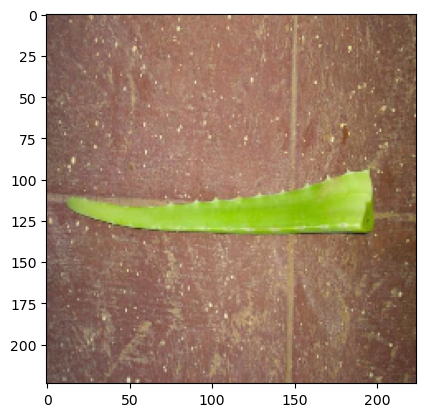

In [82]:

import cv2
out=['Aloevera',
 'Amla',
 'Amruthaballi',
 'Arali',
 'Astma_weed',
 'Badipala',
 'Balloon_Vine',
 'Bamboo',
 'Beans',
 'Betel',
 'Bhrami',
 'Bringaraja',
 'Caricature',
 'Castor',
 'Catharanthus',
 'Chakte',
 'Chilly',
 'Citron lime (herelikai)',
 'Coffee',
 'Common rue(naagdalli)',
 'Coriender',
 'Curry',
 'Doddpathre',
 'Drumstick',
 'Ekka',
 'Eucalyptus',
 'Ganigale',
 'Ganike',
 'Gasagase',
 'Ginger',
 'Globe Amarnath',
 'Guava',
 'Henna',
 'Hibiscus',
 'Honge',
 'Insulin',
 'Jackfruit',
 'Jasmine',
 'Kambajala',
 'Kasambruga',
 'Kohlrabi',
 'Lantana',
 'Lemon',
 'Lemongrass',
 'Malabar_Nut',
 'Malabar_Spinach',
 'Mango',
 'Marigold',
 'Mint',
 'Neem',
 'Nelavembu',
 'Nerale',
 'Nooni',
 'Onion',
 'Padri',
 'Palak(Spinach)',
 'Papaya',
 'Parijatha',
 'Pea',
 'Pepper',
 'Pomoegranate',
 'Pumpkin',
 'Raddish',
 'Rose',
 'Sampige',
 'Sapota',
 'Seethaashoka',
 'Seethapala',
 'Spinach1',
 'Tamarind',
 'Taro',
 'Tecoma',
 'Thumbe',
 'Tomato',
 'Tulsi',
 'Turmeric',
 'ashoka',
 'augmented_images',
 'camphor',
 'kamakasturi',
 'kepala'
 ]
img=cv2.imread("2.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(224,224))
img=img/255.
import matplotlib.pyplot as plt
plt.imshow(img)
img=img.reshape(1,224,224,3)
import numpy as np
res=main_model.predict(img)
print(res)
out[np.argmax(res)]

In [37]:
#predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(validation_generator)


55/55 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step
